# Notebook for Manifolder

Demonstration of the manifold reconstruction technique, using test data and space weather data.

The `simplified_data.csv` contains 8 channels of timeseries test data.  For simplicity, only the first channel contains the test signal, which contains a few different, repeating signal types.  All channels have low-level noise added, for numerical stability.

Running the `Manifolder` code with `Dim=3` projects the signal into an an underlying 3-dimensional manifold.  Plotting the signal, along with the underlying dimensions, gives a simple visual representation of the technique.

### Resources

[NumPy for Matlab users — NumPy v1.13 Manual](https://docs.scipy.org/doc/numpy-1.13.0/user/numpy-for-matlab-users.html)

[Getting Started with MATLAB](https://www.mathworks.com/help/matlab/getting-started-with-matlab.html)

### Running

This port strives to be as similar to the original MATLAB code as possible.  MATLAB code frequently runs the files inline, as scripts.  To do this in Python, we use the `exec()` command.

Executing files from within a notebook is useful for demonstration and debugging, since all the variables are avaible in the base naming space.

To run the code from the notebook, add the `manifolder_pkg` directory the `PYTHONPATH`.  An example in Bash would be:

```bash
PYTHONPATH=${PYTHONPATH}:~/Documents/repos/manifolder_repo/manifolder_pkg
```


In [1]:
!echo $PYTHONPATH


/Users/jonathan/Documents/repos:./:/Users/jonathan/Documents/repos/manifolder_repo/manifolder_pkg


In [2]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns

sns.set()


In [3]:
!echo $PYTHONPATH

/Users/jonathan/Documents/repos:./:/Users/jonathan/Documents/repos/manifolder_repo/manifolder_pkg



*** executing load_data.py

loading data frommanifolder_pkg/data/simple_data.csv... z.shape (8, 87660)
done!

*** executing histograms_overlap.py
calculating histograms for 8 dimensions (univariate timeseries) ........ done

*** executing covariances.py
computing local covariances .......... done

*** executing embedding.py
computing Dis matrix ..........done!
aniostropic kernel ... done
extending embedding (building Psi) ... done
*** executing clustering.py
running k-means
(17532,)
normalizing amplitueds of Psi in Python ...
(17524,)
done


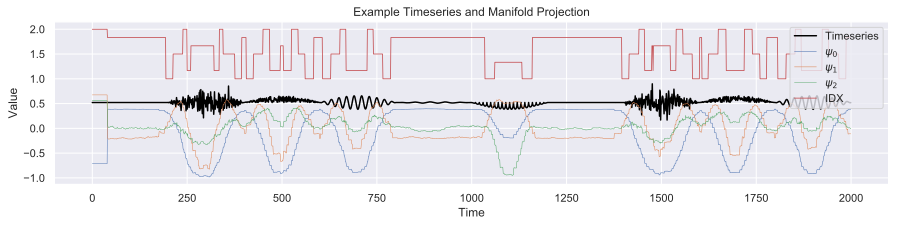

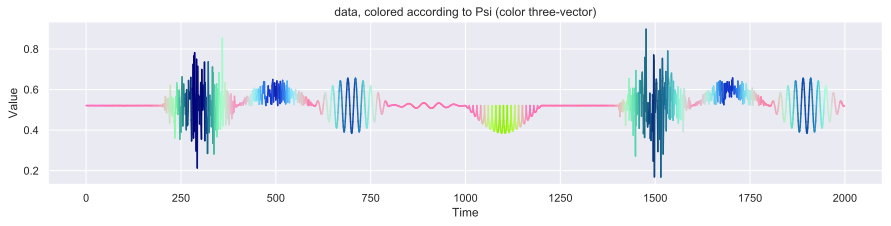


	 Program Executed in 207.53 seconds
DONE


In [4]:
### RUN THE ENTIRE CODE, HERE
#   can also run subsections individually

exec(open('manifolder_pkg/main.py').read())

print('DONE')


In [5]:
# IDX contains the index of clusters (typically ~7) ...
# need to make a dictionary, with a key for each index (0 to 6),
# the value is a list of the collection of lengths

cluster names (keys) [0 1 2 3 4 5 6]


<Figure size 432x288 with 0 Axes>

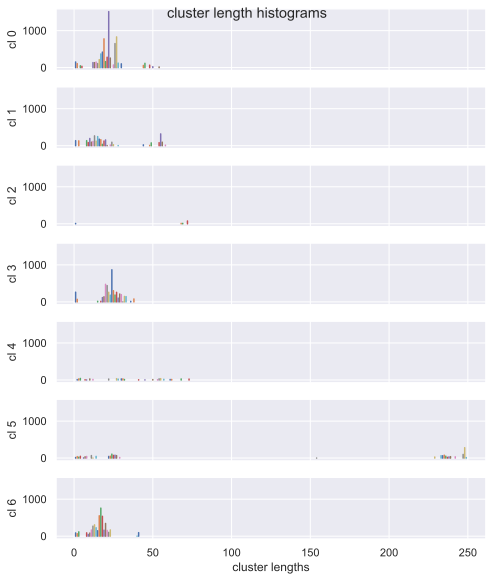

In [6]:
# clustereing data ...

cluster_lens = mh.count_cluster_lengths(IDX)

# cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# and the values are a list of clusner lengths

mh.show_cluster_lens(cluster_lens)


### Graph Transition (Markov) Matrix

The system can be though of as in one particular "state" (cluster value) at any given time.  This state $S$ can be though of as a column vector with $C$ dimensions, similar to states in quantum mechanic, where the column vector plays the role of the transition matrix.

Time evolution is this given by the tranistion matrix $M$, which is a Markov matrix (all columns sum to one, to preserve probability).  In this case, we have

$$
S_{n+1} = M @ S_n 
$$

Where the $@$ symbol is used to explicitly denote matrix multiplication.

Since most clusters with transition to themselves, the diagonal values of the matrix can be quite high, and are typically removed.  Thus, for visualization, we remove the diagonal elements of the matrix.

In [7]:
# in this case, index goes from 0 to 6 ... 
# can also have outlier groups in kmeans, need to check for this

print(IDX.shape)
print(np.min(IDX))
print(np.max(IDX))

IDX_max = np.max(IDX)


(17524,)
0
6


In [8]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)



 transition matrix:
[[2435.    0.   15.   47.    0.   56.    0.]
 [   0. 1675.    0.    0.   31.    0.   46.]
 [  15.    0.  984.    0.    0.    0.    0.]
 [  48.    0.    0. 2082.    0.    0.   47.]
 [   0.   31.    0.    0. 1084.    0.    0.]
 [  55.    0.    0.    0.    0. 7334.    1.]
 [   0.   46.    0.   48.    0.    0. 1443.]]


NOTE, need to fix bug, sometimes orders backwards

 transition matrix, ordered:
[[7334.   55.    0.    0.    1.    0.    0.]
 [  56. 2435.   47.    0.    0.    0.   15.]
 [   0.   48. 2082.    0.   47.    0.    0.]
 [   0.    0.    0. 1675.   46.   31.    0.]
 [   0.    0.   48.   46. 1443.    0.    0.]
 [   0.    0.    0.   31.    0. 1084.    0.]
 [   0.   15.    0.    0.    0.    0.  984.]]


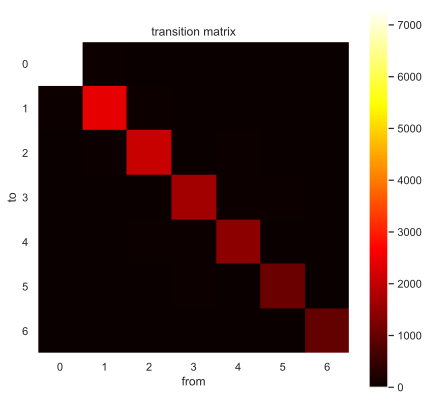

In [9]:
# reorder transition matrix, from most to least common cluster
# diagonal elements monotonically decreasing

IDX_ordered = mh.reorder_cluster(IDX, M)

M = mh.make_transition_matrix(IDX_ordered)
print('\n transition matrix, ordered:')
print(M)

mh.image_M(M)


transition matrix, diagonal elements removed, normalized (Markov)
[[0.     0.4661 0.     0.     0.0106 0.     0.    ]
 [1.     0.     0.4947 0.     0.     0.     1.    ]
 [0.     0.4068 0.     0.     0.5    0.     0.    ]
 [0.     0.     0.     0.     0.4894 1.     0.    ]
 [0.     0.     0.5053 0.5974 0.     0.     0.    ]
 [0.     0.     0.     0.4026 0.     0.     0.    ]
 [0.     0.1271 0.     0.     0.     0.     0.    ]]


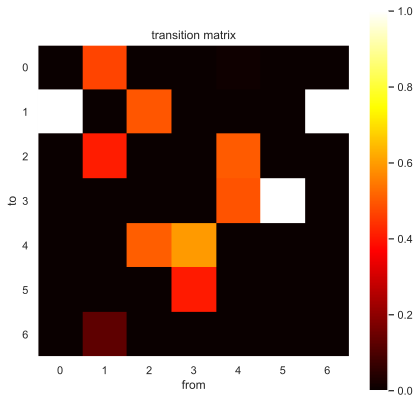

In [10]:
# remove diagonal, and make markov, for display

print('transition matrix, diagonal elements removed, normalized (Markov)')

np.fill_diagonal(M, 0)  # happens inplace
M = mh.make_matrix_markov(M)

print(M)
mh.image_M(M, 1)


### Run code again, on solar wind

In [11]:
data_location_override = 'manifolder_pkg/data/solar_wind_data.csv'


*** executing load_data.py

loading data frommanifolder_pkg/data/solar_wind_data.csv... z.shape (8, 87660)
done!

*** executing histograms_overlap.py
calculating histograms for 8 dimensions (univariate timeseries) ........ done

*** executing covariances.py
computing local covariances .......... done

*** executing embedding.py
computing Dis matrix ..........done!
aniostropic kernel ... done
extending embedding (building Psi) ... done
*** executing clustering.py
running k-means
(17532,)
normalizing amplitueds of Psi in Python ...
(17524,)
done


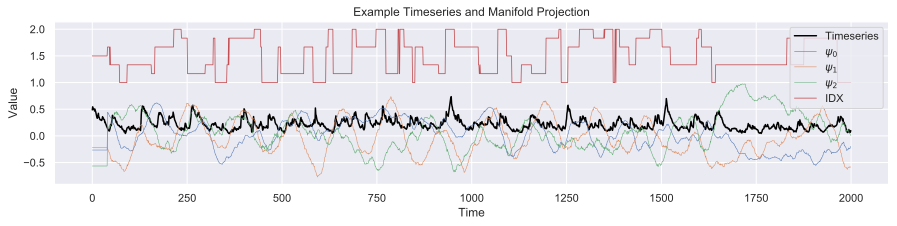

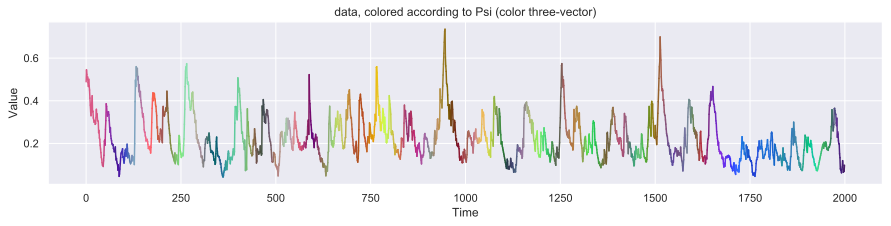


	 Program Executed in 248.68 seconds
DONE


In [12]:
### THIS RUNS THE ENTIRE CODE, HERE
#   can also run subsections individually

exec(open('manifolder_pkg/main.py').read())

print('DONE')


cluster names (keys) [0 1 2 3 4 5 6]


<Figure size 432x288 with 0 Axes>

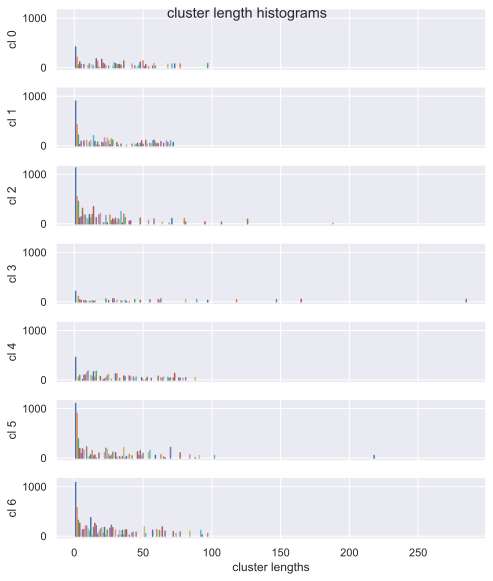

In [13]:
# clustering data ...

cluster_lens = mh.count_cluster_lengths(IDX)

mh.show_cluster_lens(cluster_lens)


In [14]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)



 transition matrix:
[[2022.    0.   28.   20.   19.   11.    5.]
 [   0. 2532.   32.    0.   22.    9.   35.]
 [  45.   23. 2456.    0.   22.   23.    6.]
 [  12.    0.    0. 1962.    1.   28.   12.]
 [  14.   25.   17.    1. 2560.    0.   29.]
 [   9.   13.   34.   19.    0. 2597.   39.]
 [   3.   37.    8.   13.   22.   43. 2715.]]


NOTE, need to fix bug, sometimes orders backwards

 transition matrix, ordered:
[[2715.   43.   22.   37.    8.    3.   13.]
 [  39. 2597.    0.   13.   34.    9.   19.]
 [  29.    0. 2560.   25.   17.   14.    1.]
 [  35.    9.   22. 2532.   32.    0.    0.]
 [   6.   23.   22.   23. 2456.   45.    0.]
 [   5.   11.   19.    0.   28. 2022.   20.]
 [  12.   28.    1.    0.    0.   12. 1962.]]


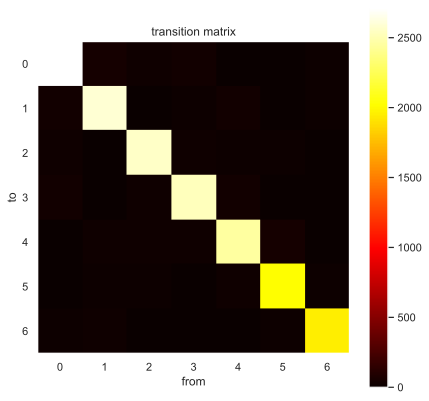

In [15]:
# reorder transition matrix, from most to least common cluster
# diagonal elements monotonically decreasing

IDX_ordered = mh.reorder_cluster(IDX, M)

M = mh.make_transition_matrix(IDX_ordered)
print('\n transition matrix, ordered:')
print(M)

mh.image_M(M)


transition matrix, diagonal elements removed, normalized (Markov)
[[0.     0.3772 0.2558 0.3776 0.0672 0.0361 0.2453]
 [0.3095 0.     0.     0.1327 0.2857 0.1084 0.3585]
 [0.2302 0.     0.     0.2551 0.1429 0.1687 0.0189]
 [0.2778 0.0789 0.2558 0.     0.2689 0.     0.    ]
 [0.0476 0.2018 0.2558 0.2347 0.     0.5422 0.    ]
 [0.0397 0.0965 0.2209 0.     0.2353 0.     0.3774]
 [0.0952 0.2456 0.0116 0.     0.     0.1446 0.    ]]


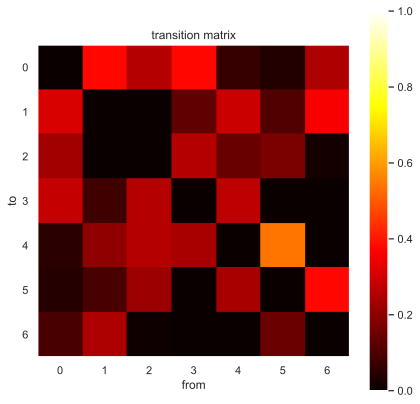

In [16]:
# remove diagonal, and make markov, for display

print('transition matrix, diagonal elements removed, normalized (Markov)')

np.fill_diagonal(M, 0)  # happens inplace
M = mh.make_matrix_markov(M)

print(M)
mh.image_M(M, 1)


### tSNE

In [17]:
assert False, 'code stops here (experimental code below)'


AssertionError: code stops here (experimental code below)

In [ ]:
from sklearn.manifold import TSNE

X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
print('X.shape', X.shape)
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)


In [ ]:
# number of dimensions are assumed to be number of rows, for TSNE
# (use transpose)

start_time = time.time()

# shorten by five
# this is set by a "stride" somewhere?
z_short = z[:, ::5]
print('z.shape', z.shape)
print('z_short.shape', z_short.shape)

z_embedded = TSNE(n_components=3).fit_transform(z_short.T)

elapsed = time.time() - start_time

print('elapsed mins:', np.round(elapsed / 60, 2))


In [ ]:
print('z_embedded.shape', z_embedded.shape)

plt.figure(figsize=[15, 3])

xref = z[0, :lim]
# from tsne
xs = z_embedded[:lim, 0] / 20  # careful (transposed)
ys = z_embedded[:lim, 1] / 20
zs = z_embedded[:lim, 2] / 20

# from manifolder
# xs = Psi[:lim, 0]   # this is shapped differently ...
# ys = Psi[:lim, 1] # this is shapped differently ...
# zs = Psi[:lim, 2] # this is shapped differently ...

plt.plot(xref, color='black', label='Timeseries')
plt.plot(xs, linewidth=.5, label='$\psi_0$')
plt.plot(ys, linewidth=.5, label='$\psi_1$')
plt.plot(zs[:lim], linewidth=.5, label='$\psi_2$')

# plt.plot(IDX[:lim]/np.max(IDX)+1,linewidth=.8,label='IDX')

plt.legend()

plt.xlabel('Time $ \\rightarrow $')
plt.ylabel('Value')


In [ ]:
mh.get_log_spaced_bins()
